<a href="https://colab.research.google.com/github/Sagredag/Taller2/blob/main/TallerIntegrador2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Subida de Archivo

In [12]:
# 1. Subida de archivo
from google.colab import files
uploaded = files.upload()

Saving golden_maq1_2025 mejorado.xlsx to golden_maq1_2025 mejorado (1).xlsx


2. Carga y limpieza

In [13]:
# 2. Carga y limpieza de datos
import pandas as pd

df = pd.read_excel('golden_maq1_2025 mejorado.xlsx')
df = df.iloc[1:].copy()

df.columns = [
    "Nº", "Tipo", "Fecha", "Desconocido1",
    "Entrada_Electr", "Salida_Electr",
    "P_Manual", "CC_Manual", "Billetero",
    "Entrada_TITO", "Salida_TITO"
]

for c in ["Entrada_Electr","Salida_Electr","Billetero"]:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df["Fecha"] = pd.to_datetime(df["Fecha"], errors='coerce')

df = df.dropna(subset=["Entrada_Electr","Salida_Electr","Billetero"]).reset_index(drop=True)

<ipython-input-13-5c9db61ab62b>:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Fecha"] = pd.to_datetime(df["Fecha"], errors='coerce')


3. Corrección de reinicios  

In [14]:
# 3. Función para corregir reinicios de contador
def corregir_diferencias_con_reset(serie, cap_valor=99999999):
    s = serie.astype(float).reset_index(drop=True)
    difs = [0]
    for i in range(1, len(s)):
        if s[i] >= s[i-1]:
            difs.append(s[i] - s[i-1])
        else:
            difs.append((cap_valor - s[i-1]) + s[i] + 1)
    return pd.Series(difs)

4. Cálculo de señales

In [15]:
# 4. Calcular señales de producción
entrada_diff    = corregir_diferencias_con_reset(df["Entrada_Electr"])
salida_diff     = corregir_diferencias_con_reset(df["Salida_Electr"])
billetero_diff  = corregir_diferencias_con_reset(df["Billetero"])

df["Prod_Electr"]    = entrada_diff - salida_diff
df["Prod_Billetero"] = billetero_diff

5. Normalización y secuencias  

In [16]:
# 5. Normalizar y crear secuencias
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Elegimos Prod_Billetero como señal principal
signal = df[["Prod_Billetero"]].values
scaler = MinMaxScaler()
signal_scaled = scaler.fit_transform(signal)

def crear_secuencias(datos, n_pasos=10):
    X, y = [], []
    for i in range(len(datos) - n_pasos):
        X.append(datos[i:i+n_pasos])
        y.append(datos[i+n_pasos])
    return np.array(X), np.array(y)

n_pasos = 10
X, y = crear_secuencias(signal_scaled, n_pasos)

6. División de datos

In [17]:
# 6. División entrenamiento / prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_mlp = X.reshape(X.shape[0], -1)
X_tr_mlp, X_te_mlp, y_tr_mlp, y_te_mlp = train_test_split(
    X_mlp, y, test_size=0.2, shuffle=False
)

7. Modelos a comparar  

In [19]:
# 7A. Modelo LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

model_lstm = Sequential([
    LSTM(64, input_shape=(n_pasos, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=20, batch_size=32, validation_split=0.1,
    verbose=0
)

# 7B. Modelo GRU
model_gru = Sequential([
    GRU(64, input_shape=(n_pasos, 1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=20, batch_size=32, validation_split=0.1,
    verbose=0
)

# 7C. Modelo MLP
from tensorflow.keras.layers import Input
model_mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_tr_mlp.shape[1],)),
    Dense(1)
])
model_mlp.compile(optimizer='adam', loss='mse')
history_mlp = model_mlp.fit(
    X_tr_mlp, y_tr_mlp,
    epochs=20, batch_size=32, validation_split=0.1,
    verbose=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# 7D. Modelo ARIMA (serie univariante)
!pip install statsmodels --quiet
from statsmodels.tsa.arima.model import ARIMA

# Convertir training signal a serie plana
train_series = signal_scaled[:len(X_train)+n_pasos].flatten()
arima_order = (1,0,1)
model_arima = ARIMA(train_series, order=arima_order).fit()
# Forecast sobre longitud de X_test
arima_pred_scaled = model_arima.forecast(steps=len(X_test))
arima_pred = scaler.inverse_transform(arima_pred_scaled.reshape(-1,1))

8. Evaluación y tabla de métricas

In [21]:
# 8. Evaluación y tabla de métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import pandas as pd, numpy as np

def desnorm(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()

results = []
for name, model, X_t, y_t in [
    ("LSTM", model_lstm,   X_test,   y_test),
    ("GRU",  model_gru,    X_test,   y_test),
    ("MLP",  model_mlp,    X_te_mlp, y_te_mlp)
]:
    y_pred = model.predict(X_t).flatten()
    y_true = desnorm(y_t)
    y_hat  = desnorm(y_pred)
    mae  = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = mean_absolute_percentage_error(y_true[y_true!=0], y_hat[y_true!=0])
    r2   = r2_score(y_true, y_hat)
    results.append([name, mae, rmse, (1-mape)*100, r2*100])

# Agregar ARIMA
y_true_arima = desnorm(y_test)
results.append([
    "ARIMA",
    mean_absolute_error(y_true_arima, arima_pred.flatten()),
    np.sqrt(mean_squared_error(y_true_arima, arima_pred.flatten())),
    (1-mean_absolute_percentage_error(
        y_true_arima[y_true_arima!=0],
        arima_pred.flatten()[y_true_arima!=0]
    ))*100,
    r2_score(y_true_arima, arima_pred.flatten())*100
])

metrics_df = pd.DataFrame(results, columns=[
    "Modelo","MAE","RMSE","Accuracy_%","R2_%"
])
metrics_df

264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Modelo,MAE,RMSE,Accuracy_%,R2_%
0,LSTM,1945.262201,5696.285496,21.685599,14.762445
1,GRU,1989.429887,5694.903714,22.057445,14.803794
2,MLP,2288.776165,5781.891416,27.352986,12.181230
3,ARIMA,2755.079268,6175.348867,33.350716,-0.177567


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


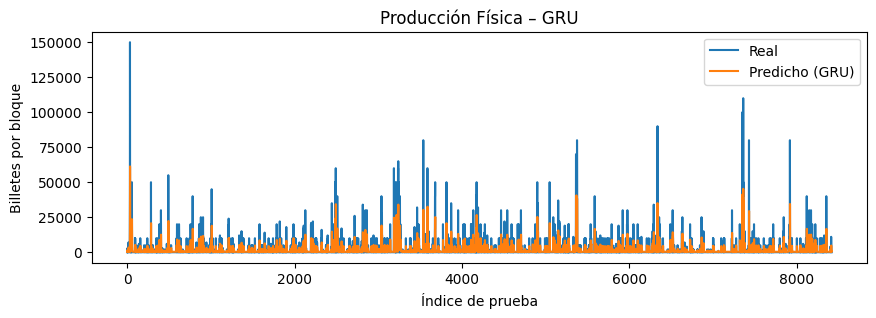

In [22]:
# Mostrar comparativa gráfica de “Real vs Predicho” para GRU
import matplotlib.pyplot as plt

y_true = desnorm(y_test)
y_gru  = desnorm(model_gru.predict(X_test).flatten())

plt.figure(figsize=(10,3))
plt.plot(y_true, label="Real")
plt.plot(y_gru,  label="Predicho (GRU)")
plt.title("Producción Física – GRU")
plt.xlabel("Índice de prueba")
plt.ylabel("Billetes por bloque")
plt.legend()
plt.show()

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


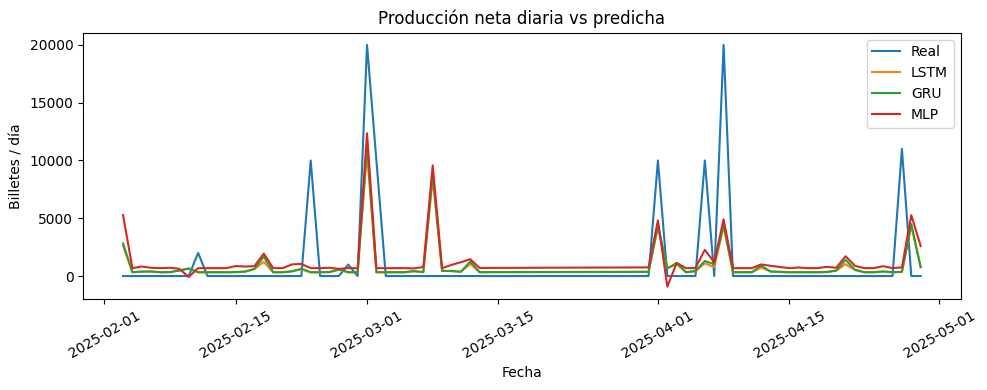

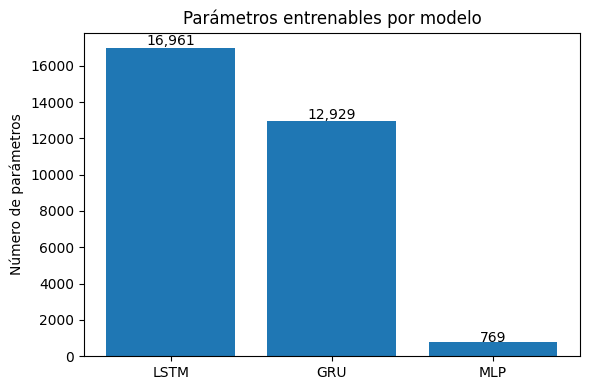

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ——————————————————————————————
# 1) Fechas del test set
# ——————————————————————————————
# El test set empieza en:
test_start = len(X_train) + n_pasos

# Extraemos las fechas correspondientes
test_dates = df['Fecha'].iloc[test_start:test_start + len(X_test)].reset_index(drop=True)
test_dates = pd.to_datetime(test_dates).dt.date

# ——————————————————————————————
# 2) Predicciones y desnormalización
# ——————————————————————————————
# Predecir en todos los modelos
pred_lstm = model_lstm.predict(X_test)
pred_gru  = model_gru.predict(X_test)
pred_mlp  = model_mlp.predict(X_te_mlp)

# Desnormalizar (función auxiliar)
def desnorm(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()

y_true = desnorm(y_test.flatten())
y_lstm = desnorm(pred_lstm.flatten())
y_gru  = desnorm(pred_gru.flatten())
y_mlp  = desnorm(pred_mlp.flatten())

# ——————————————————————————————
# 3) Crear DataFrame diario
# ——————————————————————————————
daily = pd.DataFrame({
    'Fecha': test_dates,
    'Real':   y_true,
    'LSTM':   y_lstm,
    'GRU':    y_gru,
    'MLP':    y_mlp
})

# Agrupar por día sumando todos los intervalos de 15 min
daily = daily.groupby('Fecha').sum()

# ——————————————————————————————
# 4) Gráfica: producción neta diaria vs predicha
# ——————————————————————————————
plt.figure(figsize=(10,4))
plt.plot(daily.index, daily['Real'], label='Real')
plt.plot(daily.index, daily['LSTM'], label='LSTM')
plt.plot(daily.index, daily['GRU'],  label='GRU')
plt.plot(daily.index, daily['MLP'],  label='MLP')
plt.title('Producción neta diaria vs predicha')
plt.xlabel('Fecha')
plt.ylabel('Billetes / día')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

# ——————————————————————————————
# 5) Parámetros entrenables por modelo
# ——————————————————————————————
params = {
    'LSTM': model_lstm.count_params(),
    'GRU':  model_gru.count_params(),
    'MLP':  model_mlp.count_params(),
}

plt.figure(figsize=(6,4))
bars = plt.bar(params.keys(), params.values())
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + h*0.01, f'{h:,}', ha='center')
plt.title('Parámetros entrenables por modelo')
plt.ylabel('Número de parámetros')
plt.tight_layout()
plt.show()